In [15]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [16]:
# Device configuration (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Generate a sine wave dataset
def generate_sine_wave(seq_length, total_points):
    x = np.linspace(0, total_points, total_points)
    data = np.sin(x * np.pi * 2 / 50)
    return data

In [17]:
# Prepare input sequences and targets
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        target = data[i + seq_length]
        sequences.append(seq)
        targets.append(target)
    return torch.tensor(sequences, dtype=torch.float32).unsqueeze(-1), torch.tensor(targets, dtype=torch.float32).unsqueeze(-1)

In [18]:
# Hyperparameters
SEQ_LENGTH = 20
NUM_EPOCHS = 100
LR = 0.01
HIDDEN_SIZE = 50
NUM_LAYERS = 1

In [19]:
# Create dataset
total_points = 300
data = generate_sine_wave(SEQ_LENGTH, total_points)
train_size = int(len(data) * 0.8)

train_data = data[:train_size]
test_data = data[train_size - SEQ_LENGTH:]

X_train, y_train = create_sequences(train_data, SEQ_LENGTH)
X_test, y_test = create_sequences(test_data, SEQ_LENGTH)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

C:\Users\shefa\AppData\Local\Temp\ipykernel_19604\3252221559.py:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  return torch.tensor(sequences, dtype=torch.float32).unsqueeze(-1), torch.tensor(targets, dtype=torch.float32).unsqueeze(-1)


In [20]:
# Define the RNN model
class RNNPredictor(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=1, output_size=1):
        super(RNNPredictor, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(NUM_LAYERS, x.size(0), HIDDEN_SIZE).to(device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])  # Take output of last time step
        return out

In [21]:
# Instantiate model, define loss and optimizer
model = RNNPredictor(hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)


In [22]:
# Training loop
for epoch in range(NUM_EPOCHS):
    model.train()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 0.0258
Epoch [20/100], Loss: 0.0061
Epoch [30/100], Loss: 0.0026
Epoch [40/100], Loss: 0.0001
Epoch [50/100], Loss: 0.0002
Epoch [60/100], Loss: 0.0001
Epoch [70/100], Loss: 0.0000
Epoch [80/100], Loss: 0.0000
Epoch [90/100], Loss: 0.0000
Epoch [100/100], Loss: 0.0000


In [23]:
# Evaluation
model.eval()
with torch.no_grad():
    predictions = model(X_test).cpu().numpy()
    actual = y_test.cpu().numpy()


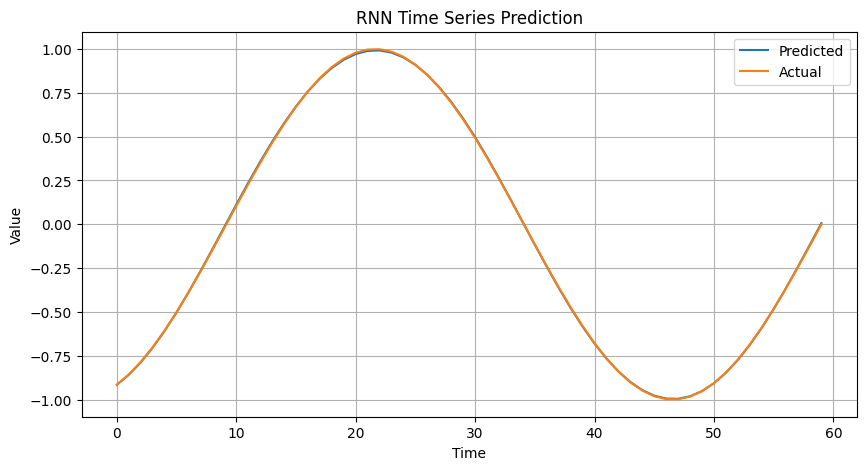

In [24]:
# Plot predictions vs actual
plt.figure(figsize=(10, 5))
plt.plot(predictions, label='Predicted')
plt.plot(actual, label='Actual')
plt.title('RNN Time Series Prediction')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()